<h3>필요한 라이브러리 import</h3>

In [9]:
import os
import math
import json
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 폰트 설정
font_path = os.path.join(os.getcwd(), 'NanumGothic.ttf')
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

<h3>평가시 필요한 함수 정의</h3>

In [10]:
# 유클리드 거리 계산 함수
def calculate_distance(x, y):
    return math.sqrt((x - 2)**2 + (y - 1)**2)

# 좌표 순서 생성 함수 (한 화면에 배치될 시퀀스를 생성하는 함수)
def generate_sequence(base_coord): 
    
    # 한 화면에는 가로4개 x 세로5개의 앱이 배치되므로 (0,0)을 좌하단으로 하는 4x5의 좌표를 생성함
    coordinates = [(x, y) for x in range(4) for y in range(5)] 
    
    # base_coord로 부터 거리가 같은 좌표들 중에서는 x 좌표가 큰 값이 우선하고, 그 다음으로는 y 좌표가 작은 값을 우선하여 정렬
    coordinates = sorted(coordinates, key=lambda pos: (calculate_distance(pos[0], pos[1]), -pos[0], pos[1]))
    return coordinates

# 화면에 띄워진 앱 로그만 선별하는 함수
def filter_foreground_apps(data):
    
    # type : MOVE_TO_FOREGROUND인 경우만 필터링 (즉, 화면에 앱이 띄워진 경우만 선별)
    app_sequence = [entry['name'] for entry in data if entry['type'] == 'MOVE_TO_FOREGROUND']
    return app_sequence

# cost 계산 함수 (여기서 cost는 손가락이 편한 위치로부터 사용하려는 앱까지의 거리)
def calculate_cost(app, apps_coordinates):
    target_coord = apps_coordinates.get(app, None)
    cost = calculate_distance(target_coord) # 기준점으로 부터 유클리드 거리 계산
    return cost

# cost 총합 계산 함수
def calculate_total_costs(app_sequence, apps_coordinates, page_size):
    total_cost = 0
    last_page = 0
    for app in app_sequence:
        if app in apps_coordinates:
            current_page = (list(apps_coordinates.keys()).index(app) // page_size)
            if last_page != current_page:
                total_cost += 3 * abs(current_page - last_page)  # 페이지가 바뀌면 cost 3 추가
            last_page = current_page
            total_cost += calculate_cost(app, apps_coordinates)
    return total_cost

# 모든 사용자의 cost 총합 평균 계산
def calculate_average_cost(total_costs):
    return np.mean(list(total_costs.values()))

# 평가시 비용 계산을 위한 함수
def get_cost(app_list, user_list, dist):
    total_cost = 0 # 해당 사용자의 총 비용
    page_now = 0 # 시작 페이지
    
    for target_app in user_list: # 사용한 앱마다
        for page_index, page in enumerate(app_list): # 각 페이지를 순회하며
            if target_app in page: # 해당 앱을 페이지에서 찾음
                
                # 페이지내 해당 앱의 인덱스
                app_index = page.index(target_app)
                
                # 거리와 페이지 인덱스를 고려하여 해당 앱 사용시 드는 비용 계산
                if page_index != page_now :
                    app_cost = dist[app_index] + (abs(page_index - page_now) * 3) # 페이지 변경시 1페이지당 3씩 비용을 더함
                    page_now = page_index
                else:
                    app_cost = dist[app_index]
                    
                total_cost += app_cost
                break
                
    return total_cost

<h3>메인 함수</h3>

In [17]:
if __name__ == "__main__":

    # 평가할 폴더
    result_folder = os.path.abspath('../clustering_results')
    '''다른 알고리즘에 대해 평가할 경우 위 폴더 이름을 바꾸시면 됩니다. #clustering results #genetic results, #apriori results '''

    if not os.path.exists(result_folder):
        print(f"경로가 존재하지 않습니다: {result_folder}")
        
    else:    
        # 앱 배치 최적화 결과를 저장한 파일명들
        result_files = [f for f in os.listdir(result_folder) if f.endswith('.json')]
        result_files.sort(key=lambda x: int(x.split('user')[1].split('.json')[0]))
    
        dist = [calculate_distance(x, y) for x,y in generate_sequence((2,1))] # 배치 순서에 따른 비용을 미리 계산해 놓은 것
        total_cost = 0 # 모든 사람의 총 비용
        total_files = len(result_files) # 파일 개수
        page_size = 20 # 한 페이지의 크기 (한 페이지에 들어갈 수 있는 앱 개수)
    
        # 각 결과 파일들에 대해, 해당 사용자의 test데이터를 불러와서 평가
        for result_file in result_files:
            user_id = int(result_file.split('user')[1].split('.json')[0])  # 파일명에서 user_id 추출
    
            file_path = f"../user_data_test/user{user_id}_test.json" # test 데이터 로드
            if not os.path.exists(file_path):
                print(f"파일을 찾을 수 없습니다: {file_path}")
                continue
    
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
    
            app_sequence = filter_foreground_apps(data) # test 데이터로부터 앱 순서 추출
    
            # 사용한 앱 순서에 따른 비용을 누적해가며 최적화된 앱 배치 결과를 평가
            with open(os.path.join(result_folder, result_file), 'r', encoding='utf-8') as file:
                final_app_list = json.load(file)
    
                final_app_list = [final_app_list[i:i + page_size] for i in range(0, len(final_app_list), page_size)] # page_size(20)개씩 분할하여 페이지화
    
                cost = get_cost(final_app_list[0], app_sequence, dist) # 해당 사용자의 총 비용 계산
                print(f"user{user_id}의 cost 총합: {cost}") # 해당 사용자의 총 비용 출력
    
                total_cost += cost # 모든 사용자의 총 비용에 누적
    
        print(f"모든 사용자 평균: {total_cost / total_files}") # 모든 사용자의 총 비용을 평균내어 출력

user1의 cost 총합: 660.1324445935618
user2의 cost 총합: 5708.845175714955
user3의 cost 총합: 15426.953976602414
user4의 cost 총합: 8305.784710453665
user5의 cost 총합: 8058.211293626015
user6의 cost 총합: 2470.629514327512
user7의 cost 총합: 6382.426065948034
user8의 cost 총합: 3292.391271206385
user9의 cost 총합: 9421.330228647825
user10의 cost 총합: 7145.586746785697
user11의 cost 총합: 4115.664933752436
user12의 cost 총합: 2882.4620679581244
user13의 cost 총합: 6485.894094449063
user14의 cost 총합: 3227.1195744973925
user15의 cost 총합: 2308.1588878425096
user16의 cost 총합: 0.0
user17의 cost 총합: 1872.4560601302214
user18의 cost 총합: 7054.210499925473
user19의 cost 총합: 5377.856058484543
user20의 cost 총합: 3463.8689111935964
user21의 cost 총합: 1719.0928558533747
user22의 cost 총합: 5863.301073226511
user23의 cost 총합: 1703.8788432671693
user24의 cost 총합: 11930.6939239682
user25의 cost 총합: 4789.645907158631
user26의 cost 총합: 4962.628262027173
user27의 cost 총합: 10746.017837900994
user28의 cost 총합: 4099.835538275109
user29의 cost 총합: 5333.630952646388


<h3>앱 배치 시각화용</h3>

In [18]:
# 앱별 좌표 시각화 함수
def visualize_app_coordinates(user_id, apps, coordinate_sequence, page_size):

    # 페이지 넘버 초기화
    page_number = 1
    
    # 앱 목록을 넘겨받은 좌표 순서대로 좌표에 매핑
    apps_coordinates = {app: coordinate_sequence[i % page_size] for i, app in enumerate(apps)}
    
    # 각 페이지마다 시각화
    for idx, (app, coord) in enumerate(apps_coordinates.items()):
        
        # 좌표별 앱 시각화
        x, y = coord
        plt.scatter(x, y, label=app, s=100)
        
        # 페이지 내 마지막 앱 또는 전체 목록의 마지막 앱 처리
        if (idx + 1) % page_size == 0 or (idx + 1) == len(apps):
            plt.title(f'User{user_id}의 페이지{page_number}')
            plt.xlim(-0.5, 3.5)
            plt.ylim(-0.5, 4.5)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
            page_number += 1

C:\Users\PC\AppData\Local\Temp\ipykernel_28508\4234764666.py:23: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


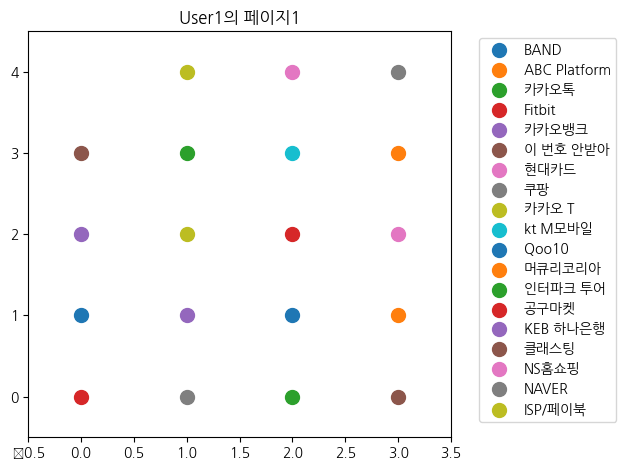

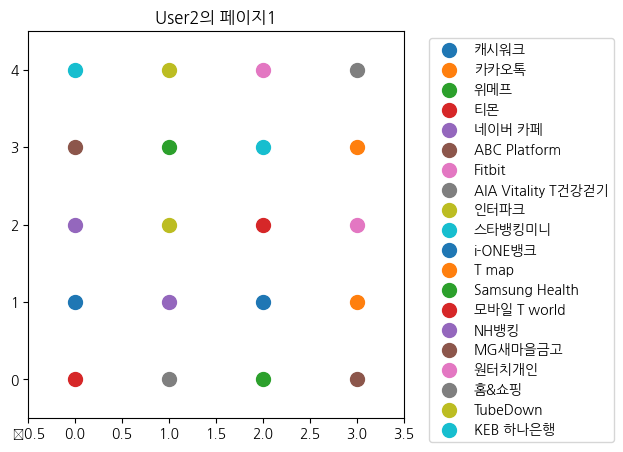

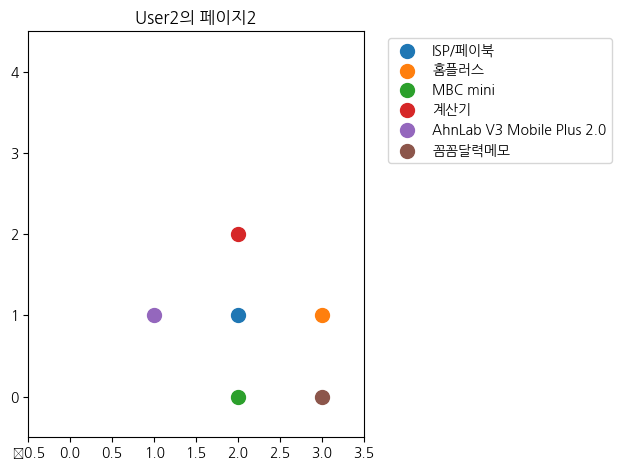

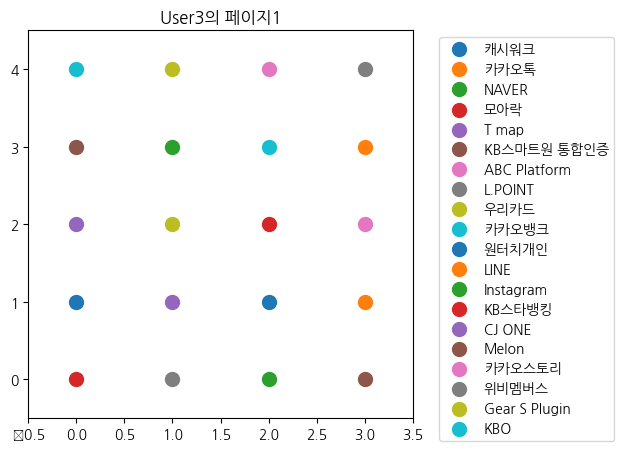

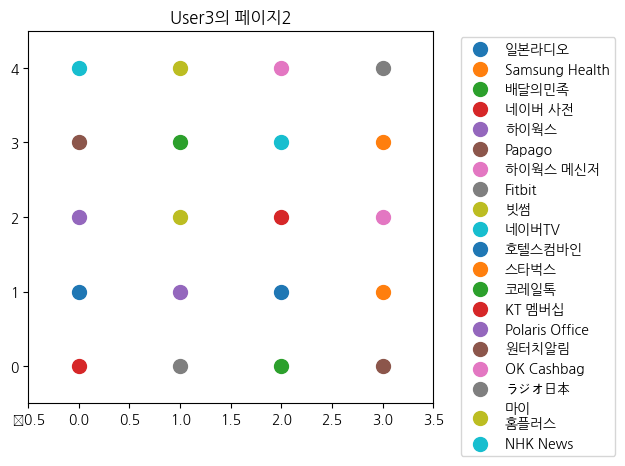

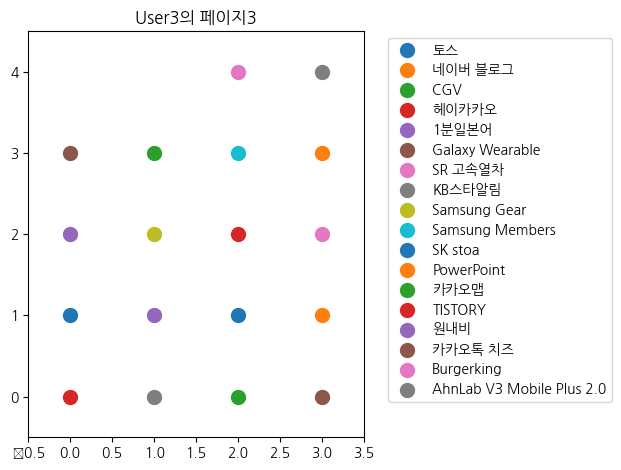

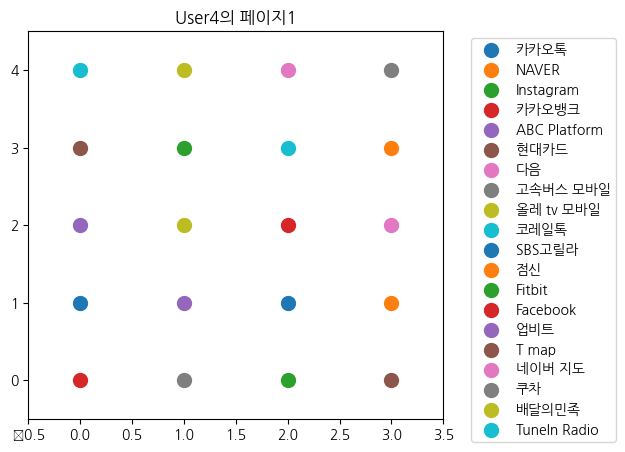

C:\Users\PC\AppData\Local\Temp\ipykernel_28508\4234764666.py:23: UserWarning: Glyph 8288 (\N{WORD JOINER}) missing from current font.
  plt.tight_layout()


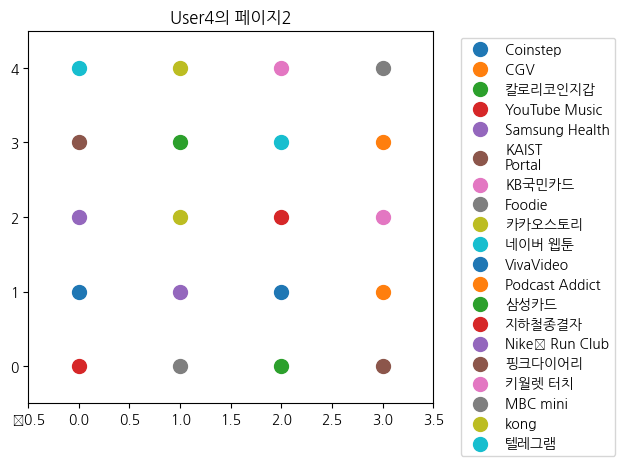

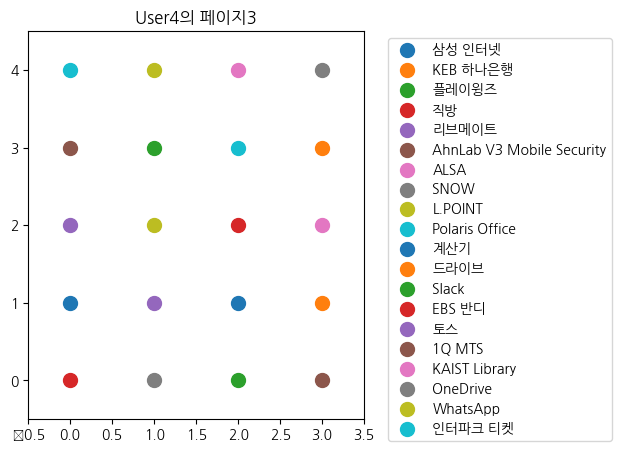

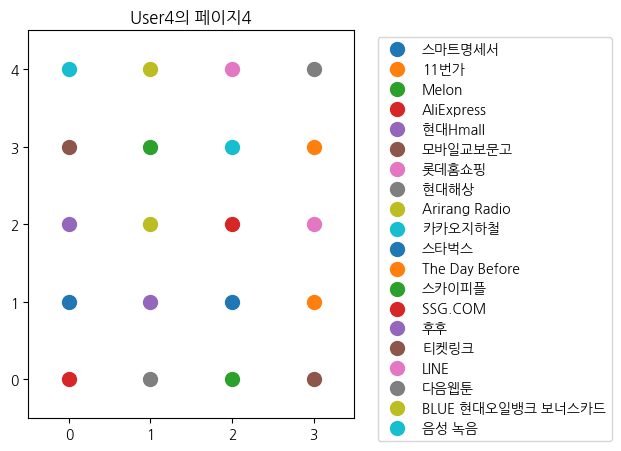

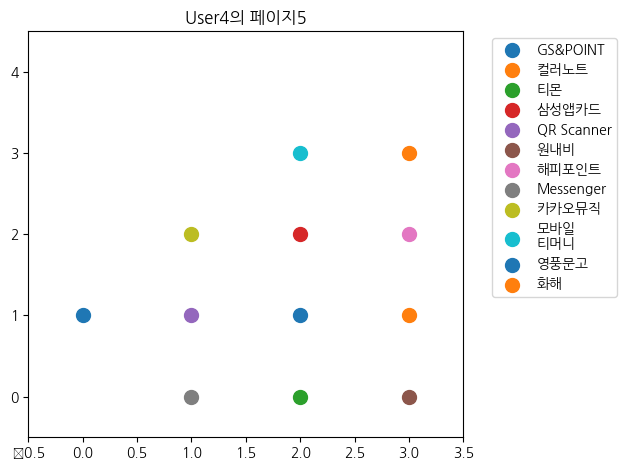

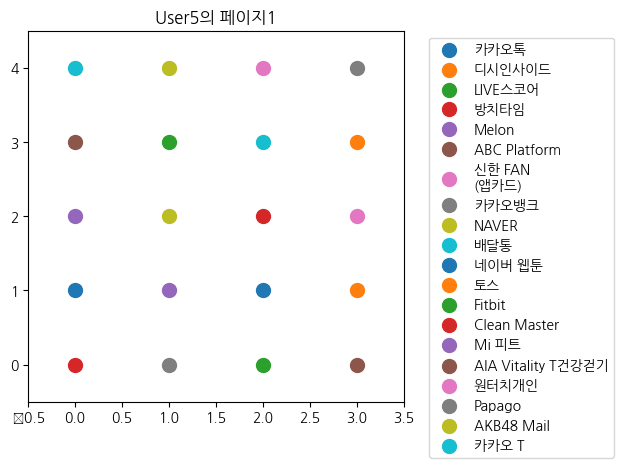

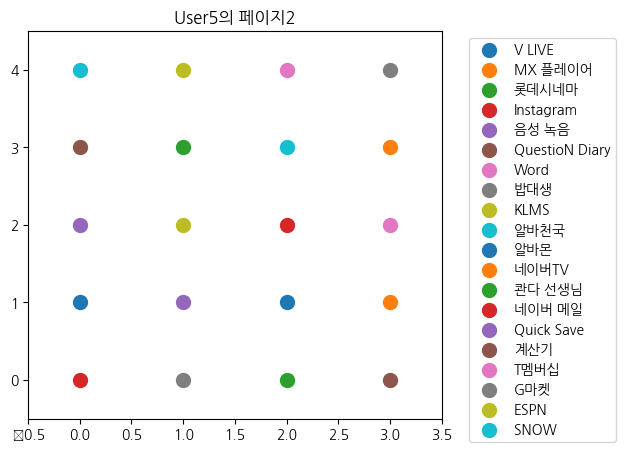

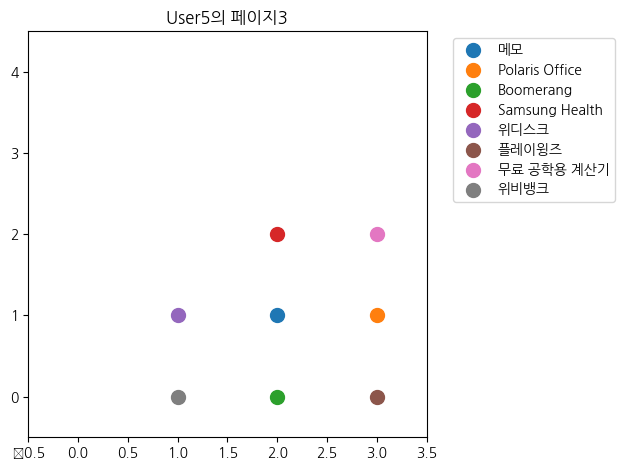

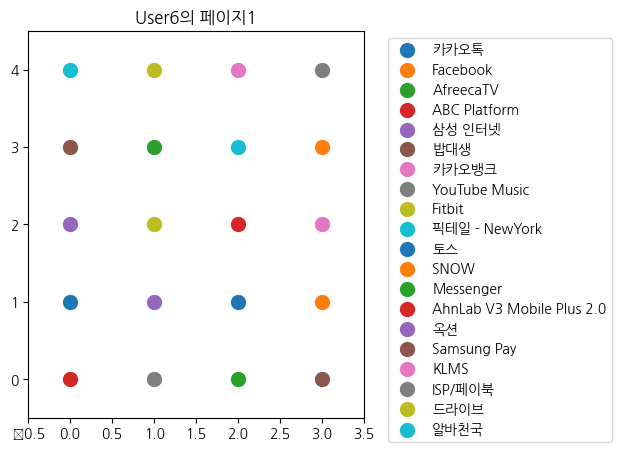

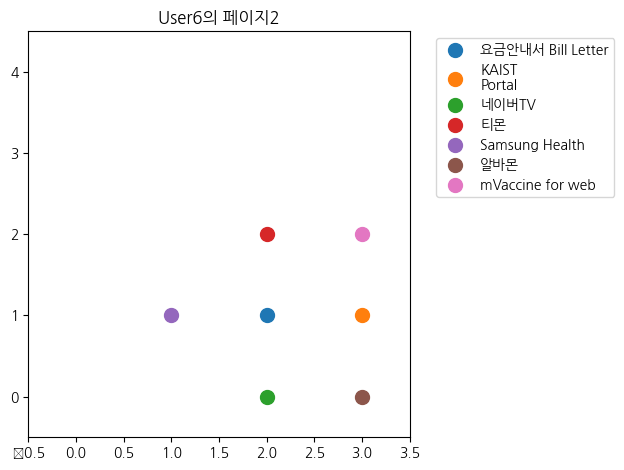

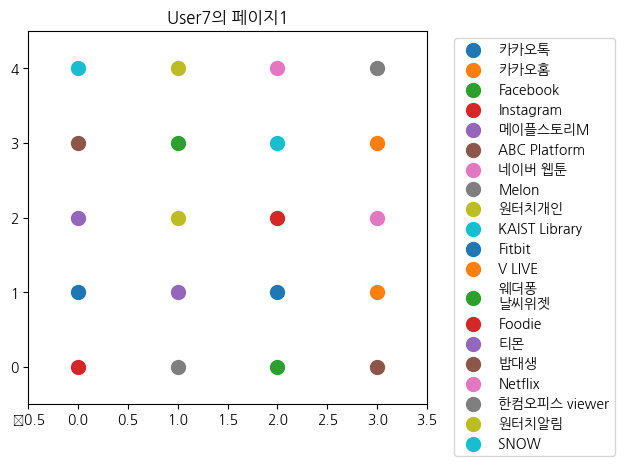

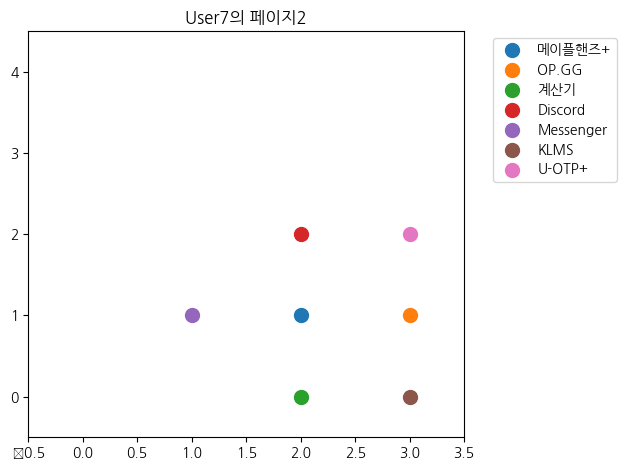

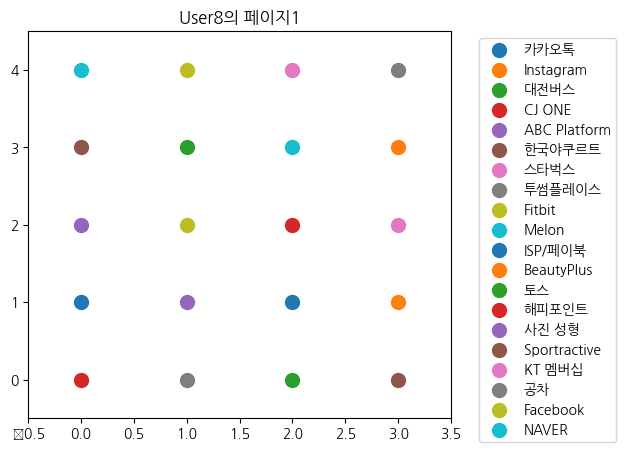

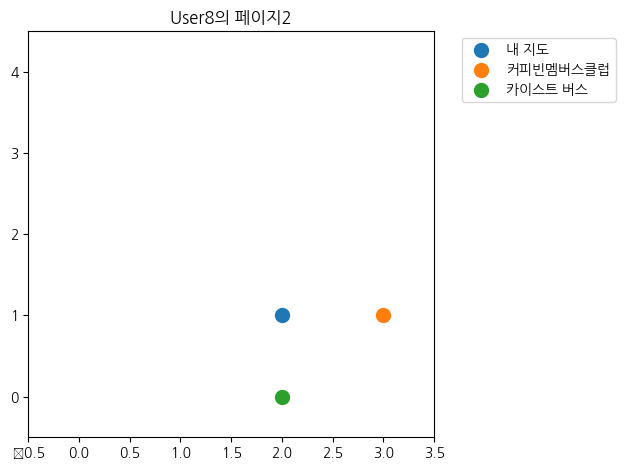

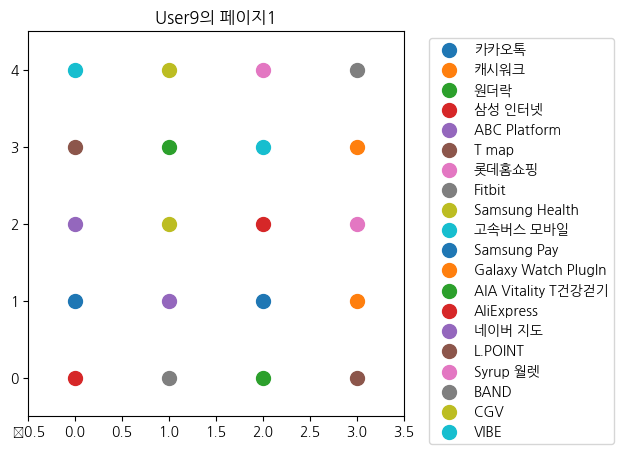

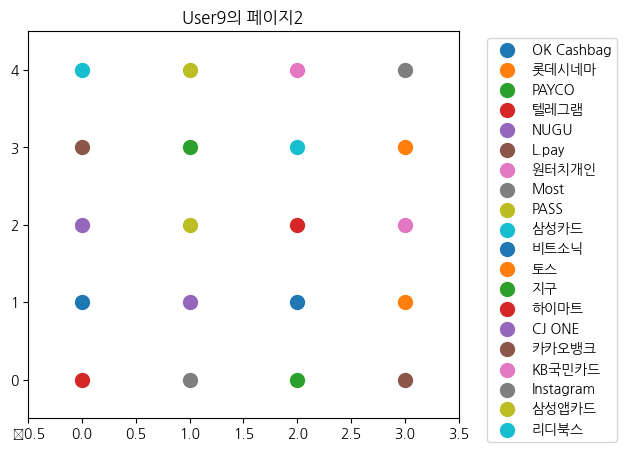

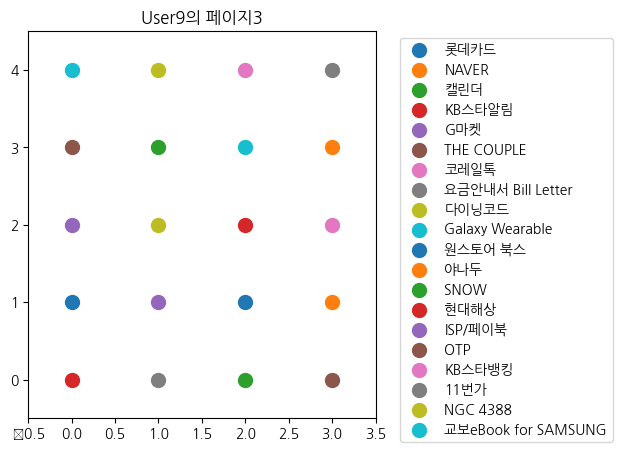

C:\Users\PC\AppData\Local\Temp\ipykernel_28508\4234764666.py:23: UserWarning: Glyph 8203 (\N{ZERO WIDTH SPACE}) missing from current font.
  plt.tight_layout()


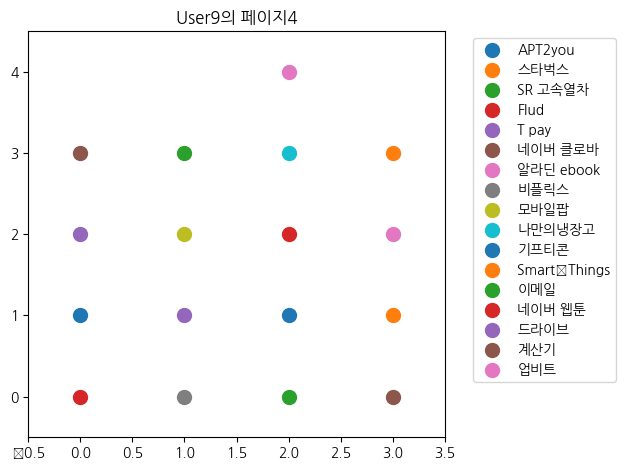

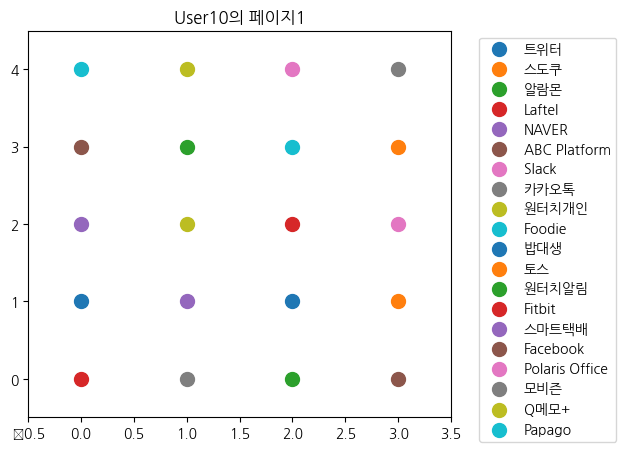

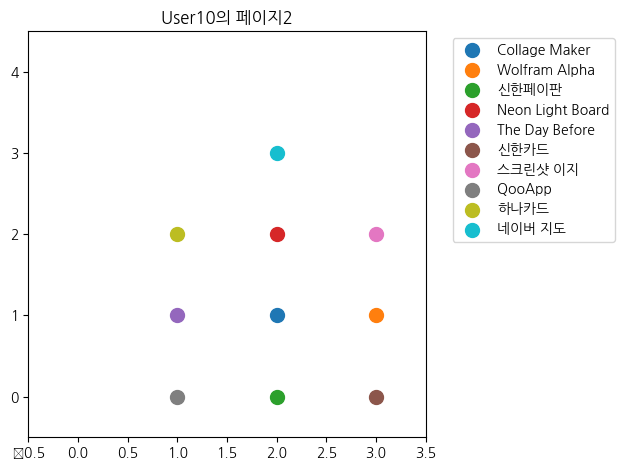

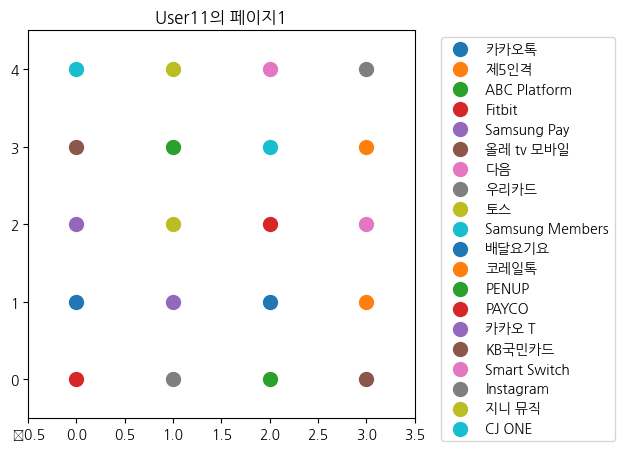

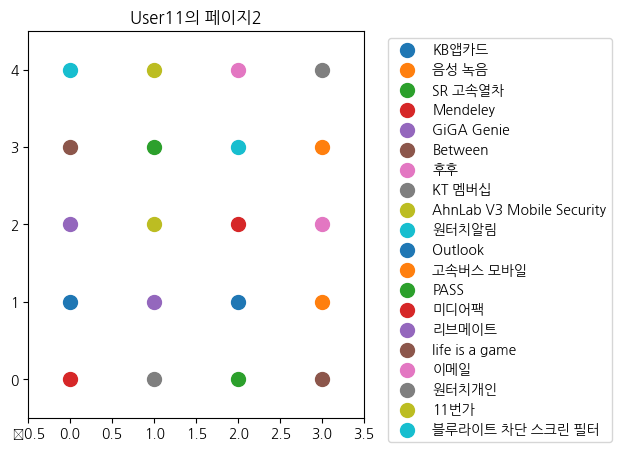

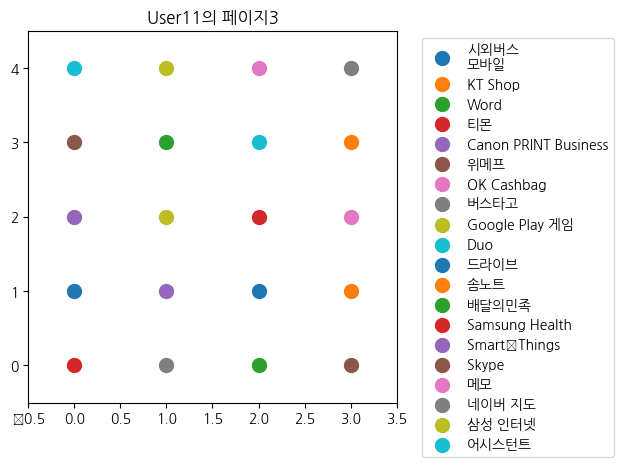

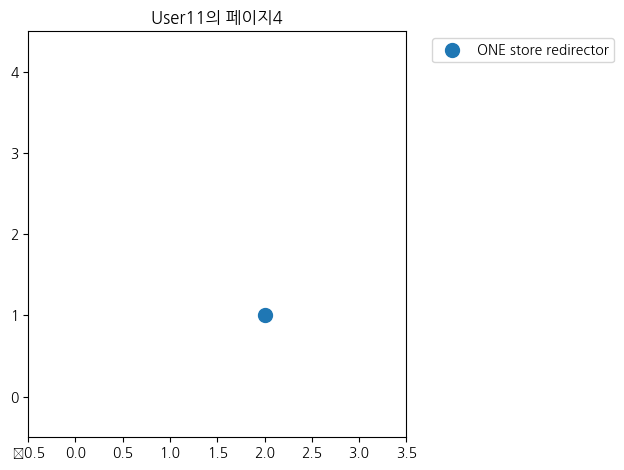

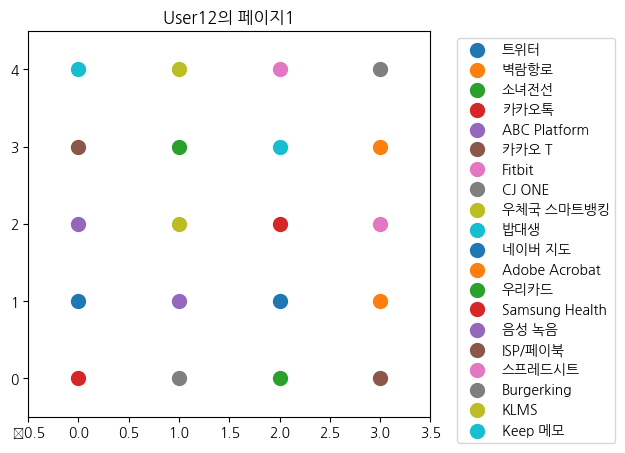

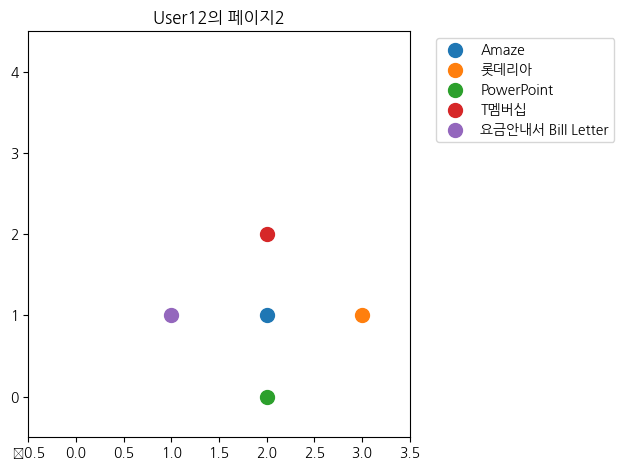

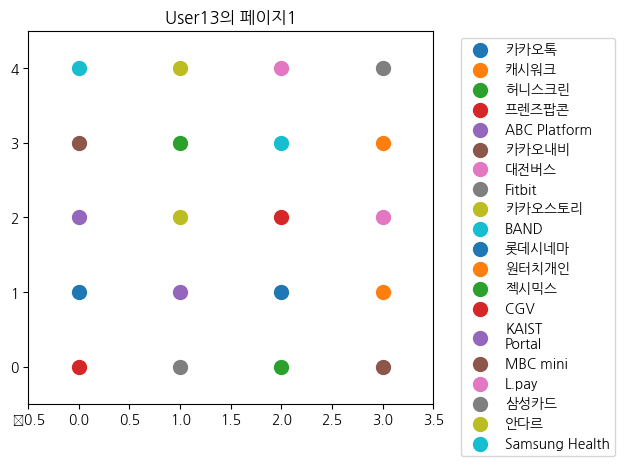

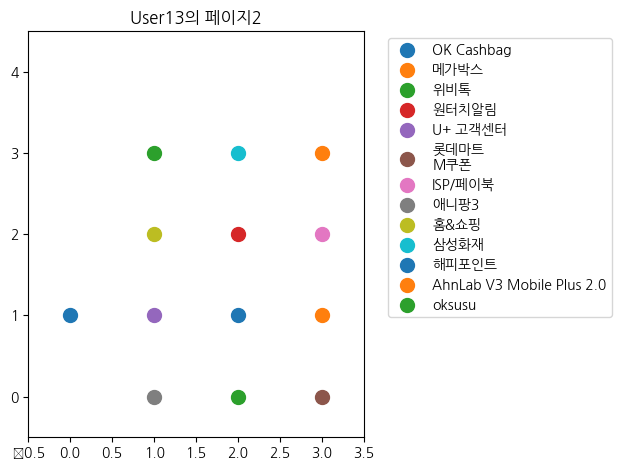

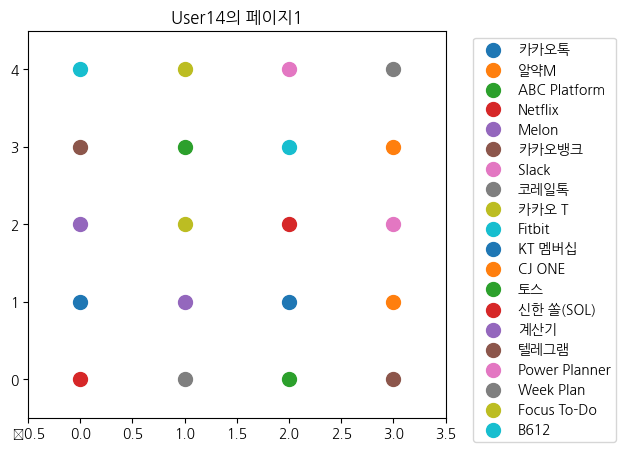

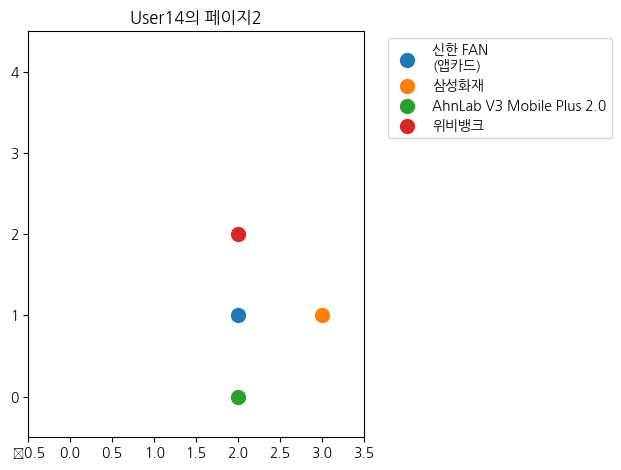

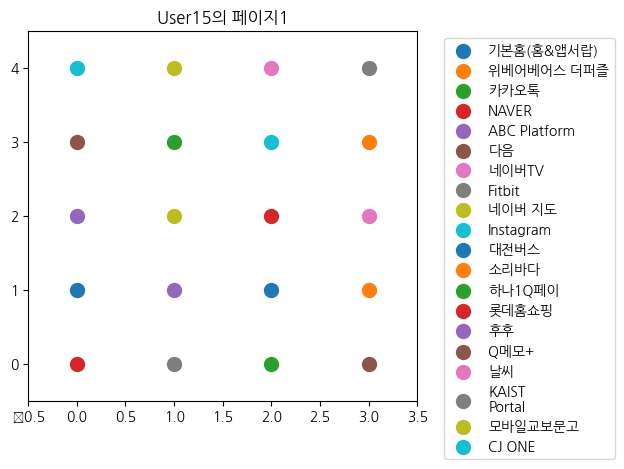

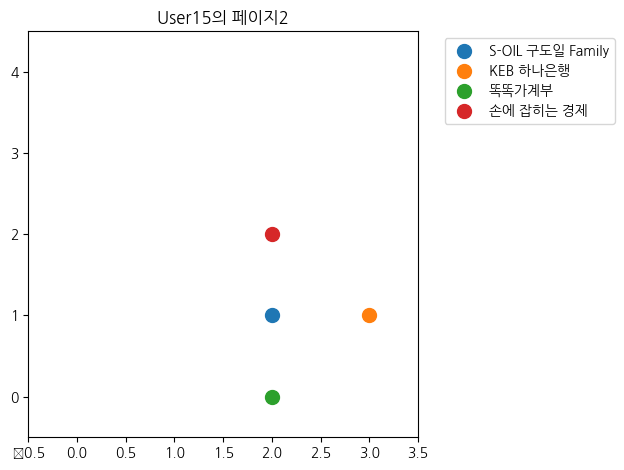

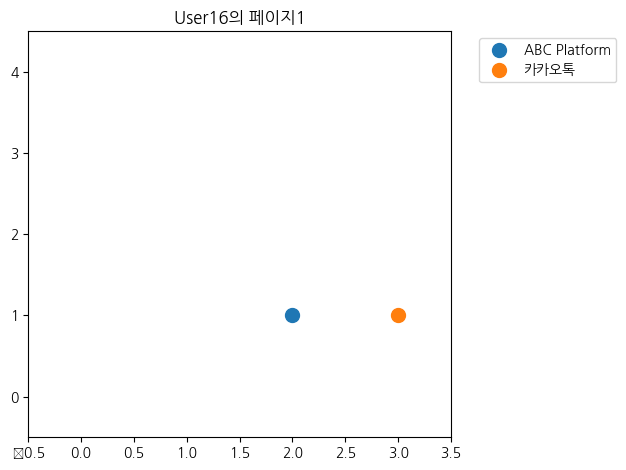

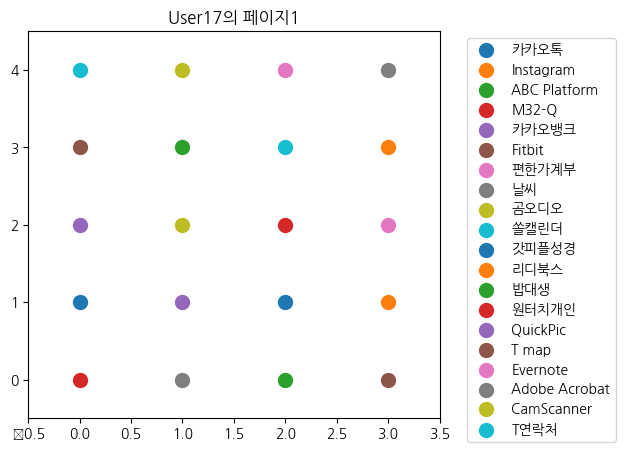

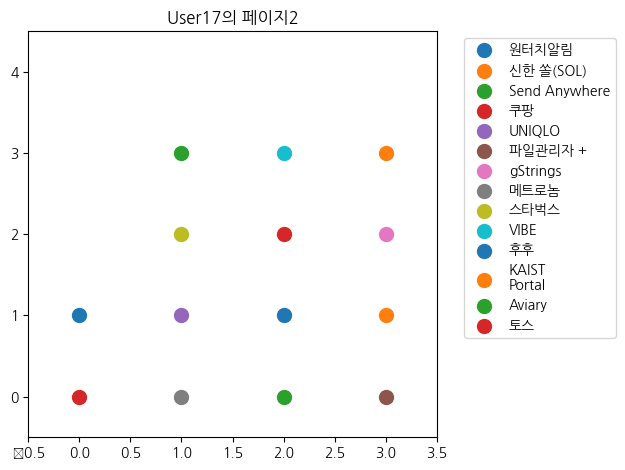

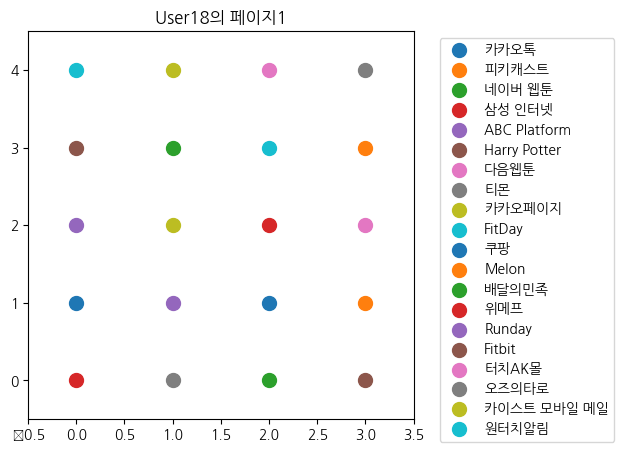

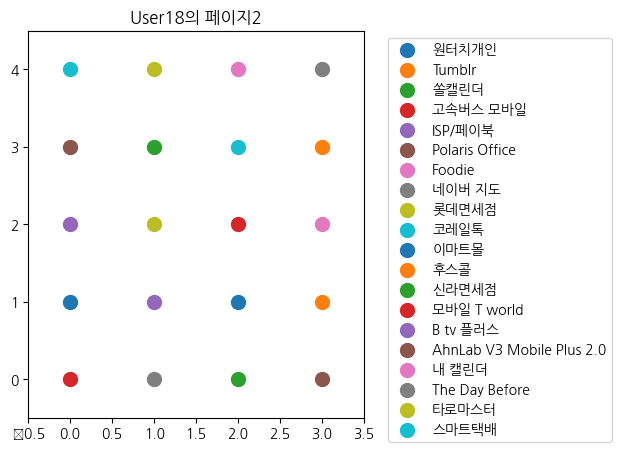

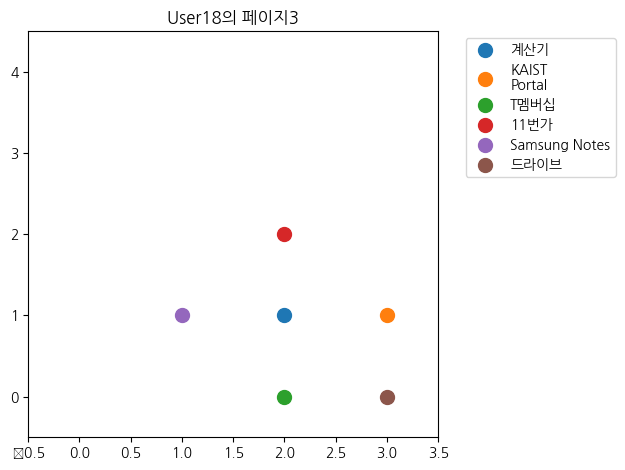

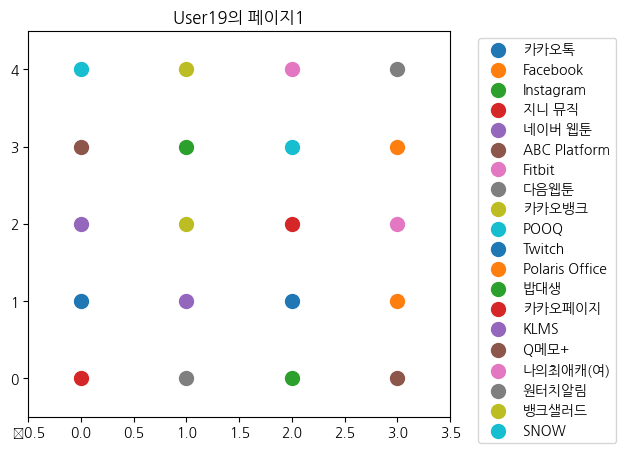

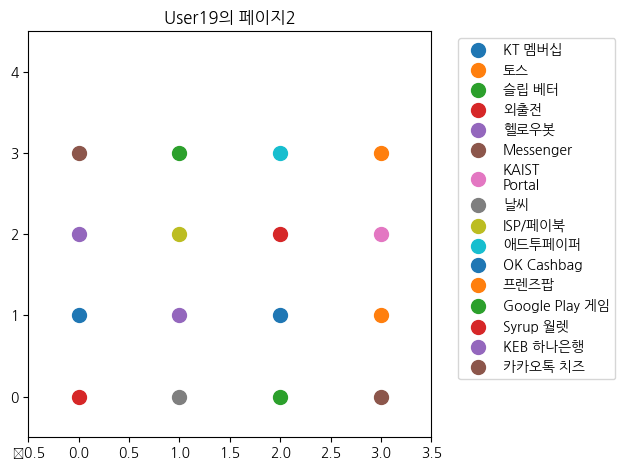

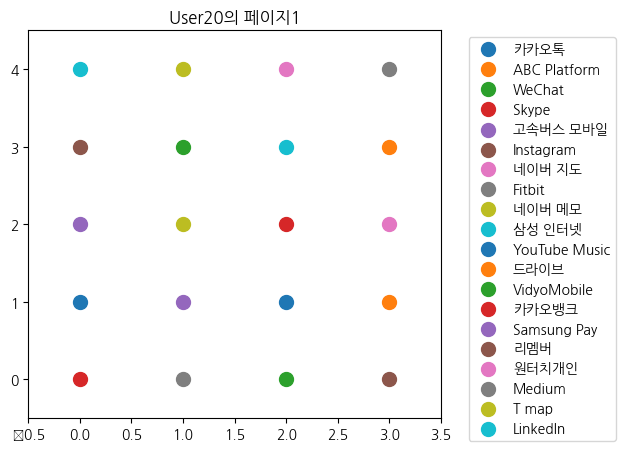

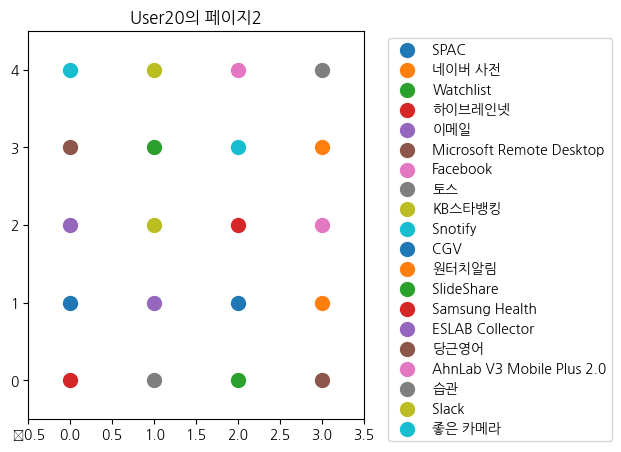

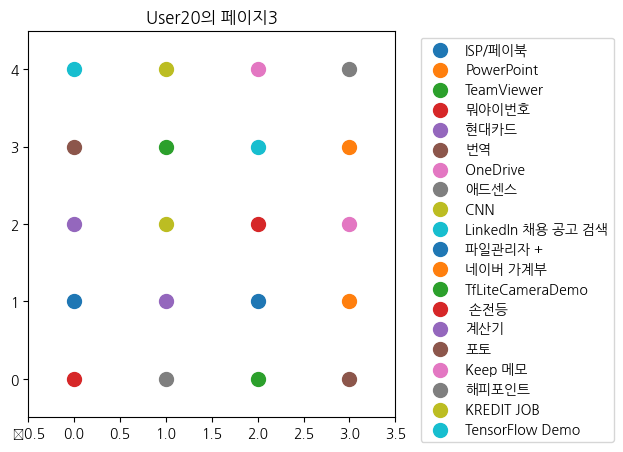

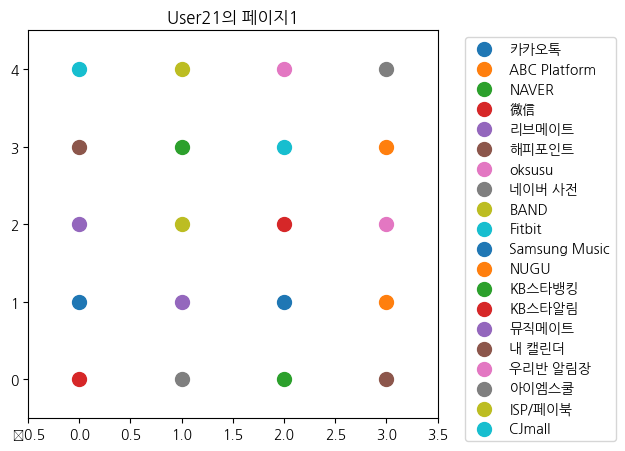

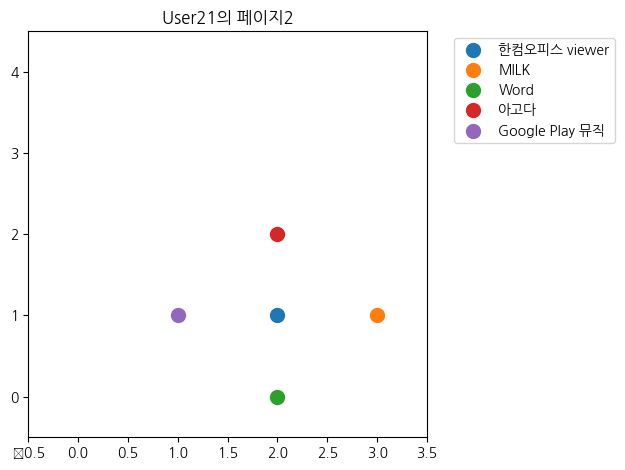

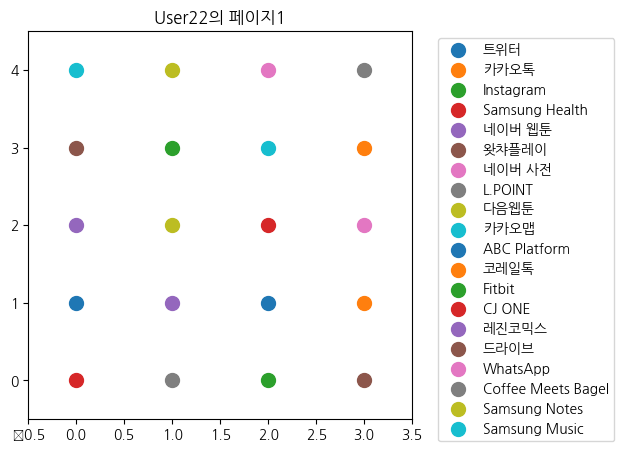

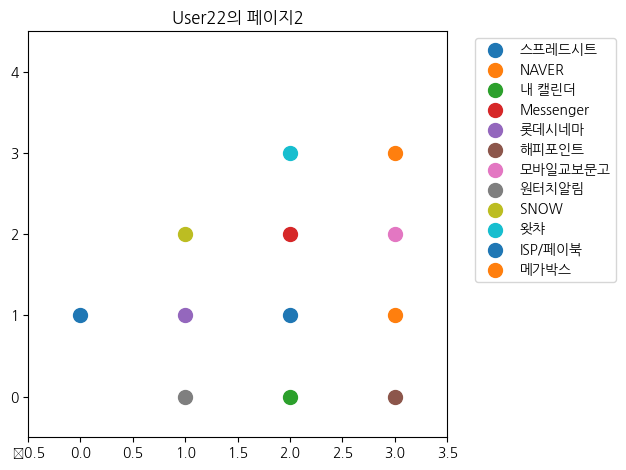

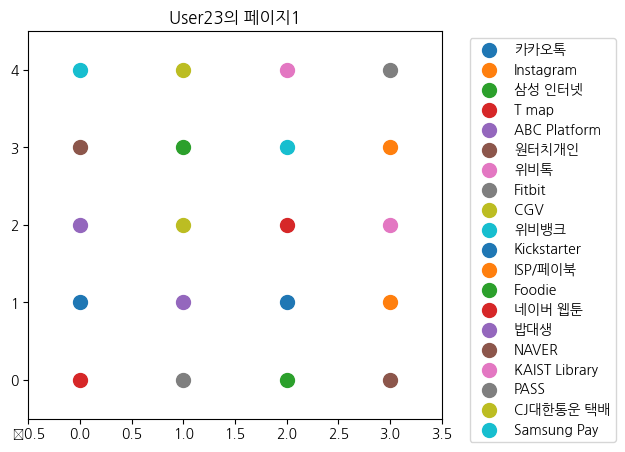

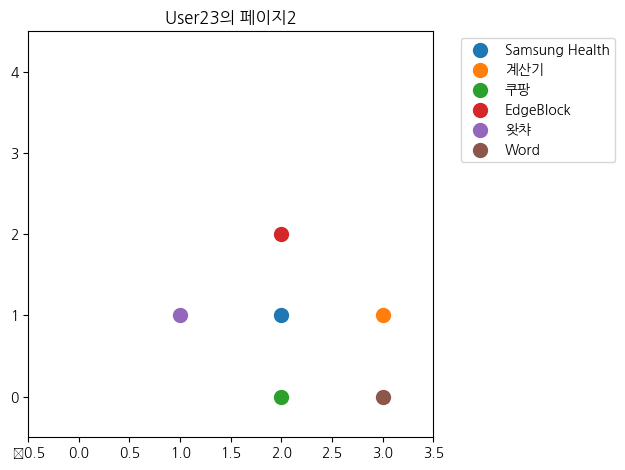

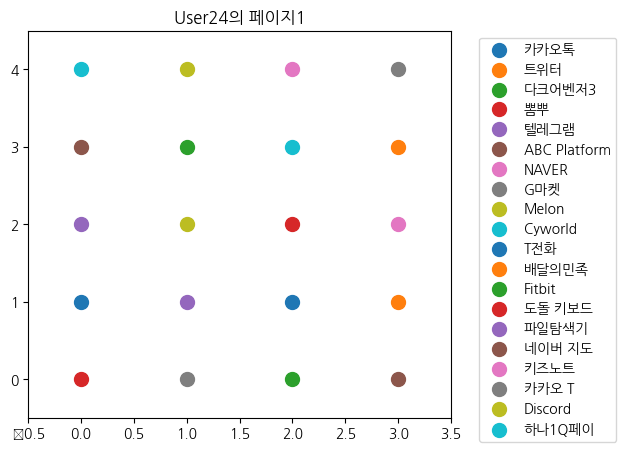

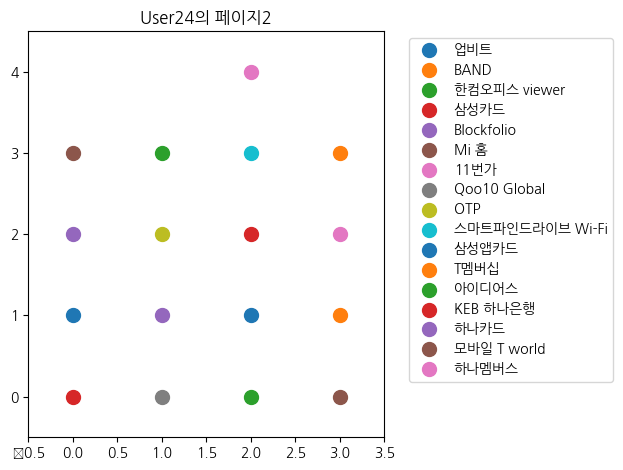

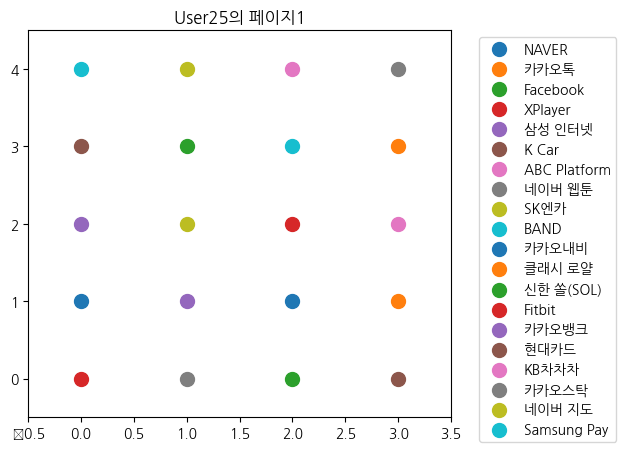

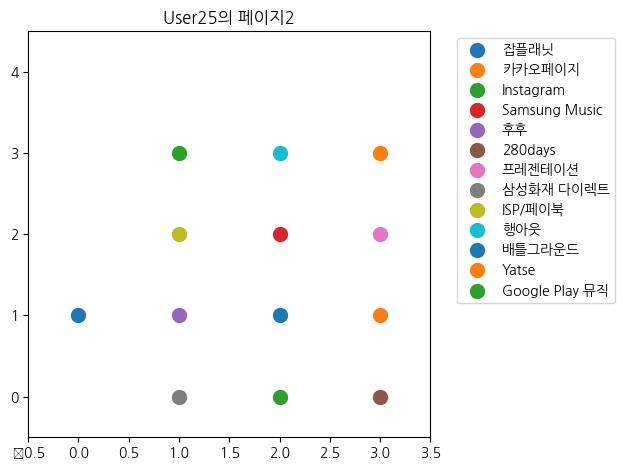

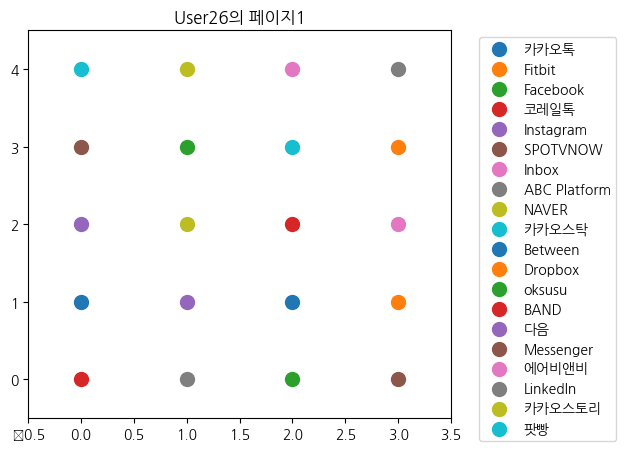

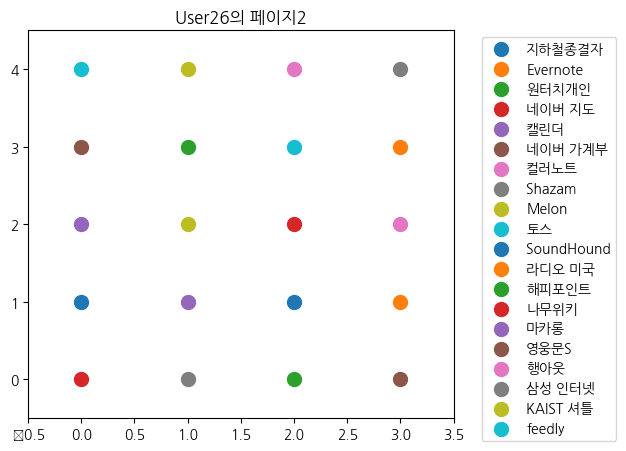

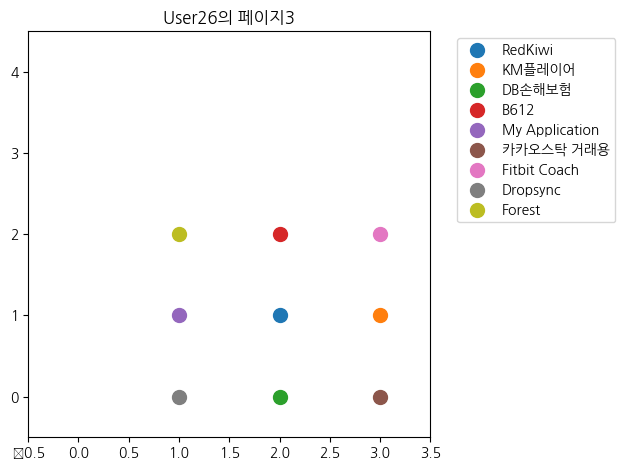

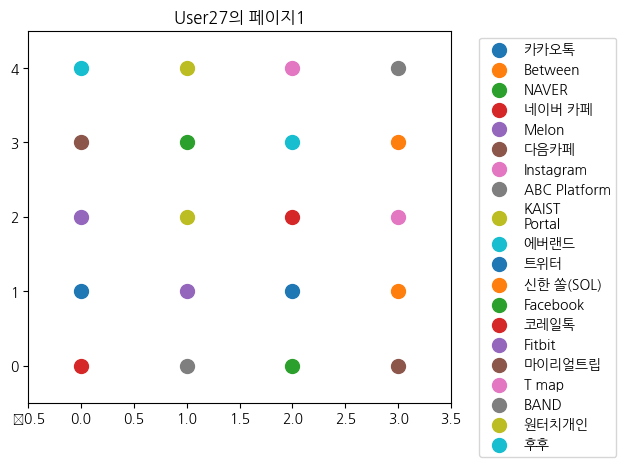

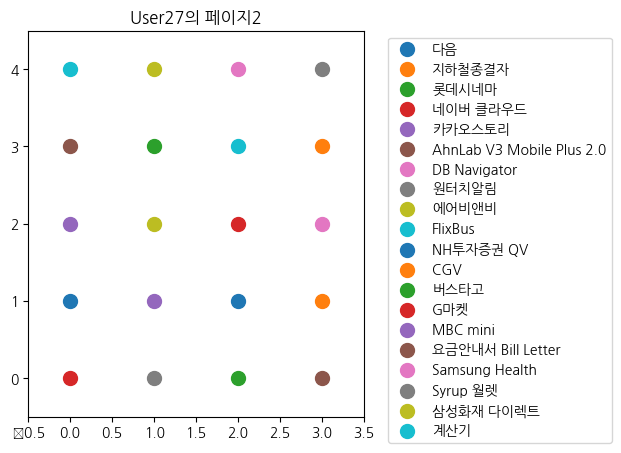

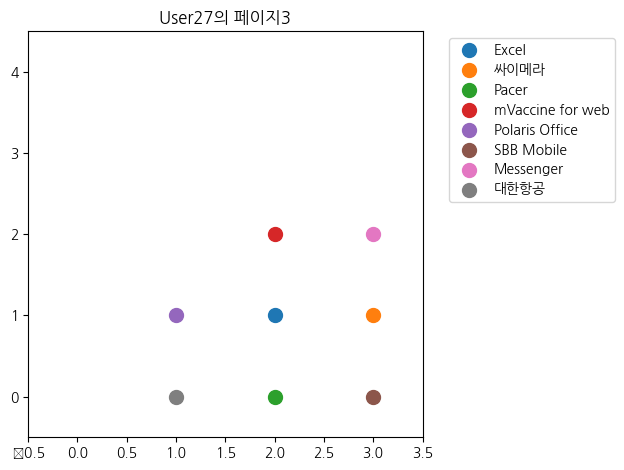

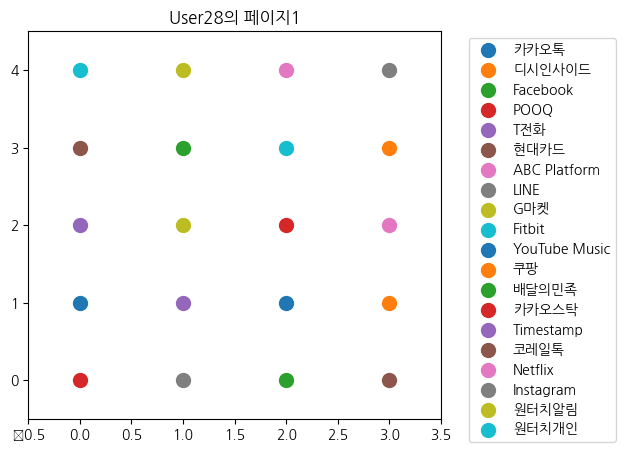

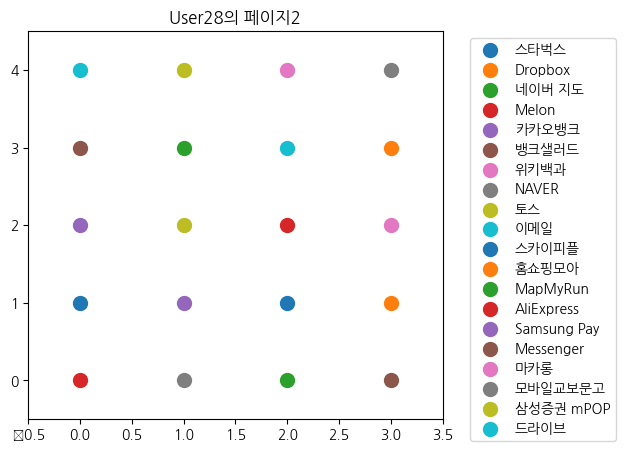

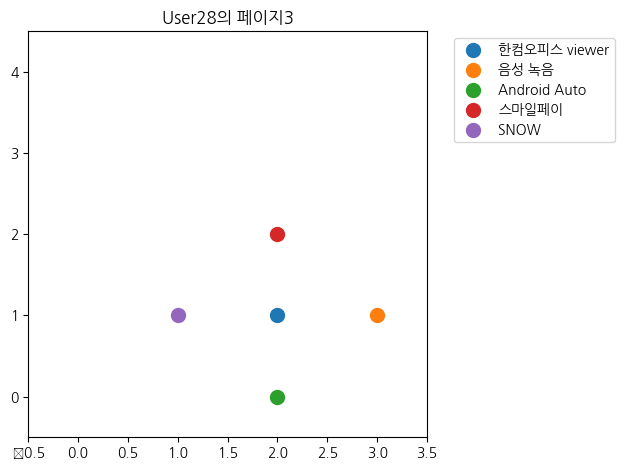

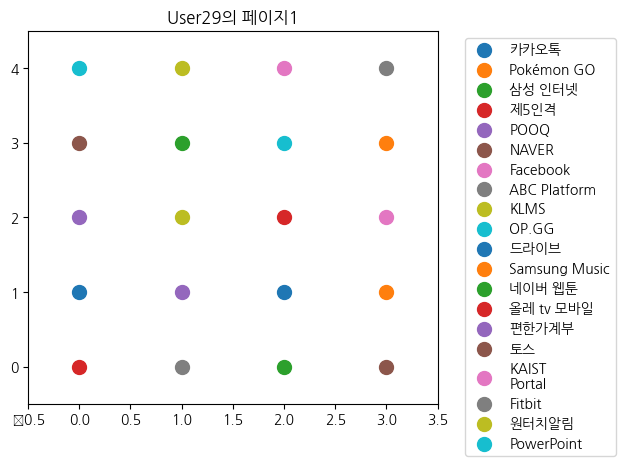

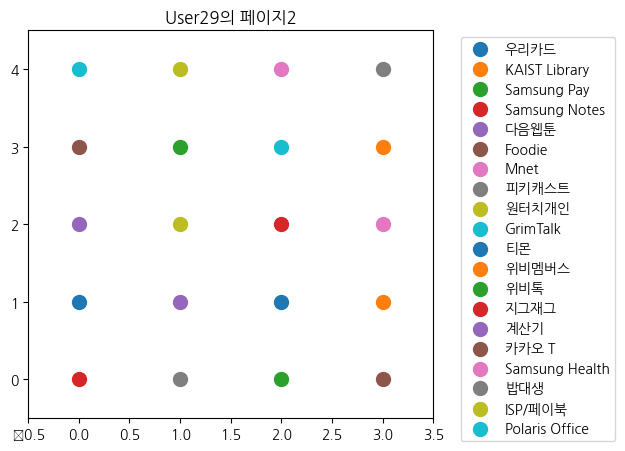

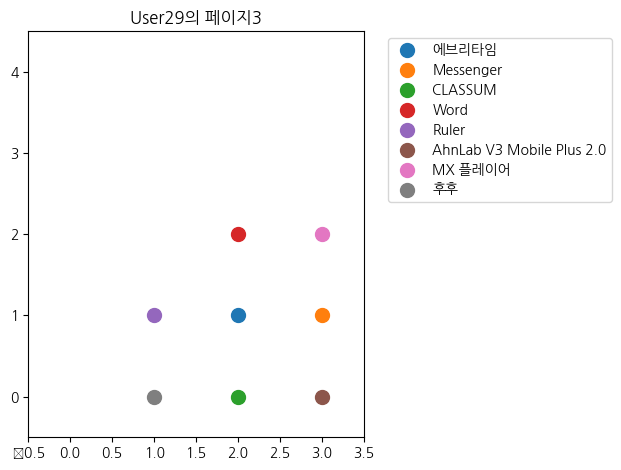

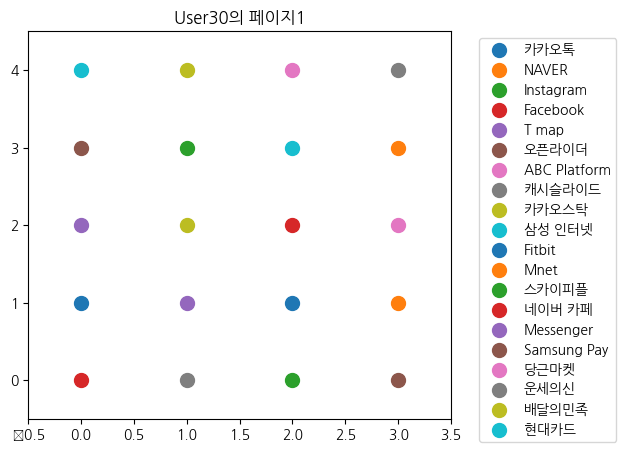

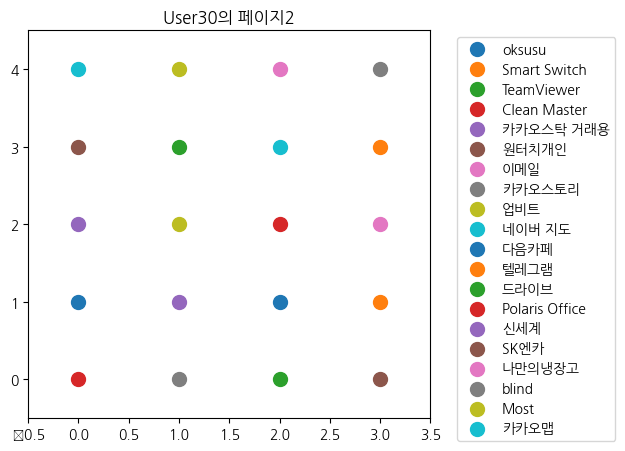

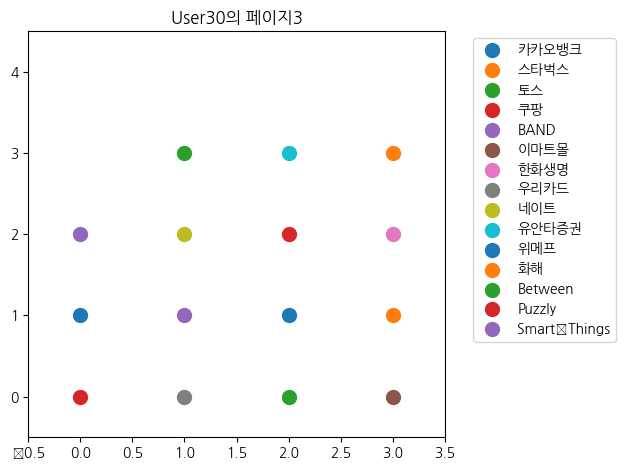

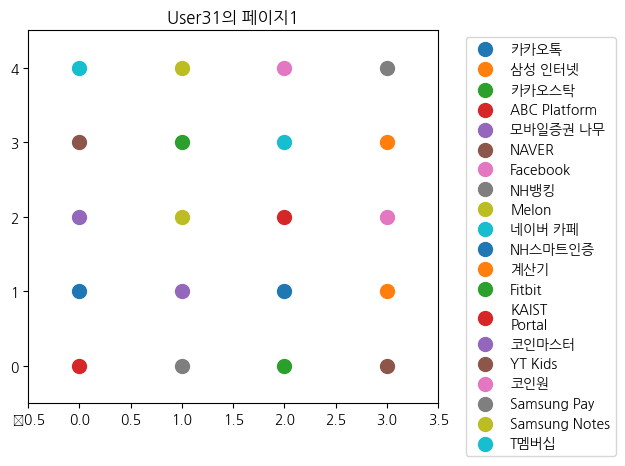

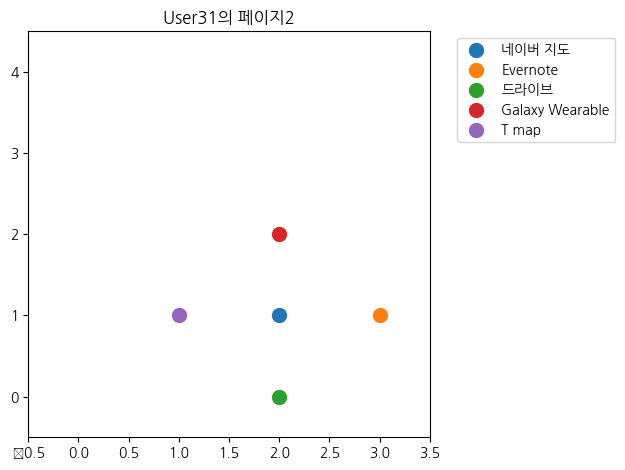

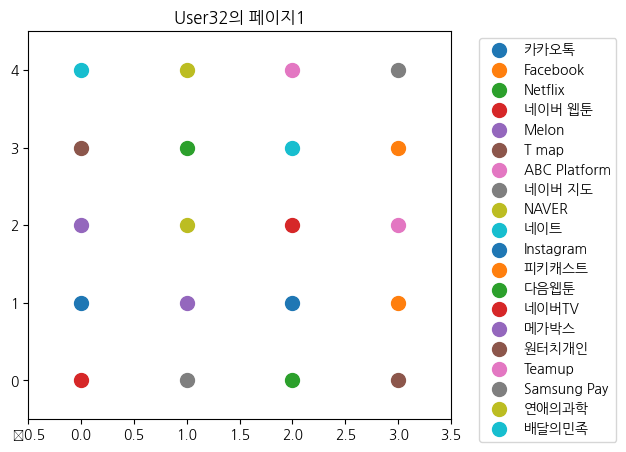

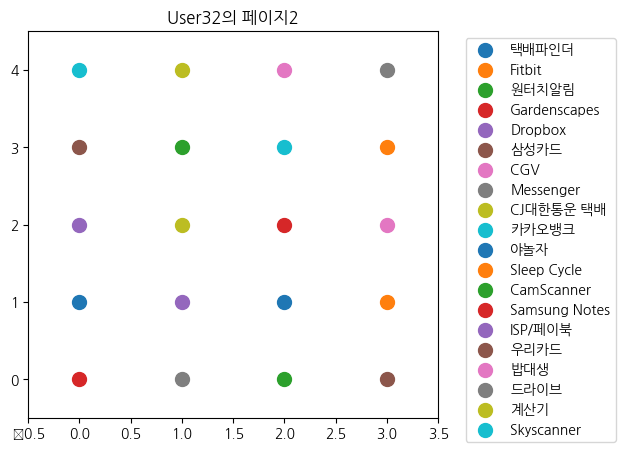

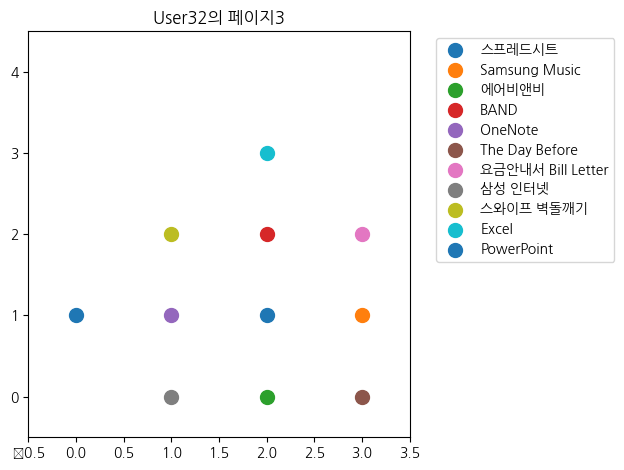

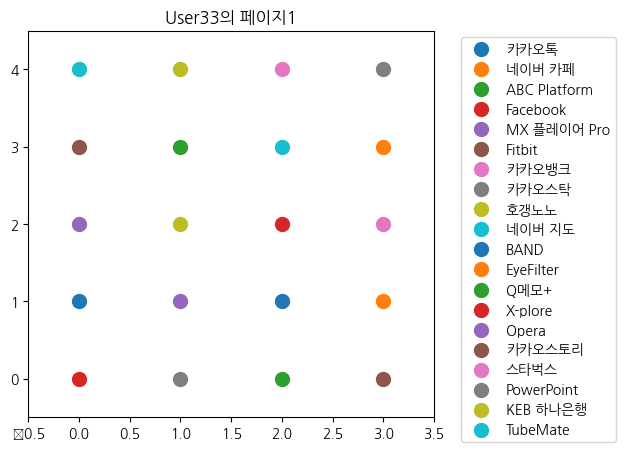

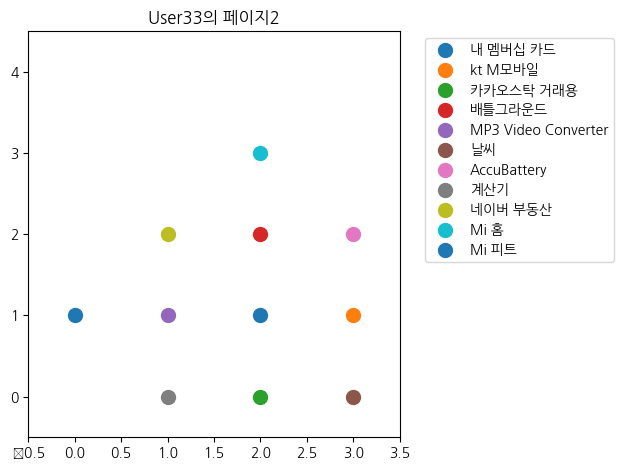

In [19]:
# 앱 좌표 시각화 (스마트폰 가로4 x 세로5 화면에 앱 배치)

# 배치 완료한 결과 파일들 불러오기
result_folder = os.path.abspath('../clustering_results')
'''다른 알고리즘에 대해 평가할 경우 위 폴더 이름을 바꾸시면 됩니다. #clustering results #genetic results, #apriori results '''

if not os.path.exists(result_folder):
    print(f"경로가 존재하지 않습니다: {result_folder}")
else:     
    # 파일 목록을 user_id 기준으로 정렬
    result_files = sorted(
        [f for f in os.listdir(result_folder) if f.endswith('.json')],
        key=lambda x: int(x.split('user')[1].split('.json')[0])
    )
    
    # 우선적으로 할당할 좌표 순서
    coordinate_sequence = generate_sequence((2,1))
    
    for result_file in result_files:
        user_id = int(result_file.split('user')[1].split('.json')[0])  # 파일명에서 user_id 추출
        file_path = os.path.join(result_folder, result_file)  # JSON 파일 로드
        if not os.path.exists(file_path):
            print(f"파일을 찾을 수 없습니다: {file_path}")
            continue
        
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
        # 앱 목록을 1차원 배열로 변환
        apps = [app for sublist in data for app in sublist]
        
        # 사용자별 앱 좌표 시각화
        visualize_app_coordinates(user_id, apps, coordinate_sequence, page_size)
